## <font color=blue>Jupyter Setup<font/>

###  Import required libraries:

In [1]:
# surprise libraries
from surprise import Dataset, dataset, Reader, accuracy
from surprise.dataset import DatasetAutoFolds
from surprise.trainset import Trainset
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split
from surprise.prediction_algorithms import SVD, knns, baseline_only
#from surprise.similarities import cosine, msd, pearson

In [3]:
# sklearn libraries
from sklearn.metrics.pairwise import linear_kernel

In [12]:
#general libraries
import pandas as pd
import numpy as np
import math
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from random import randint
%matplotlib inline

In [5]:
pd.set_option('display.max_columns', 600)

**<font color=black>----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------<font>**

## <font color=blue>Data Load<font/>

### Load data:

In [6]:
ratings = pd.read_csv('/Users/flatiron/Downloads/ml-latest-small/' + 'ratings.csv')

movies = pd.read_csv('/Users/flatiron/Downloads/ml-latest-small/' + 'movies.csv')

links = pd.read_csv('/Users/flatiron/Downloads/ml-latest-small/' + 'links.csv')

tags = pd.read_csv('/Users/flatiron/Downloads/ml-latest-small/' + 'tags.csv')

**<font color=black>----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------<font>**

## <font color=blue>Model Builds</font>


## Collaborative Models

### Ratings data preprocessing:

In [7]:
# drop the timestamp column
ratings_clean = ratings.drop('timestamp', axis = 1)

In [8]:
class MyDataset(dataset.DatasetAutoFolds):
    #   surprise.dataset.DatasetAutoFolds creates a Surprise friendly dataset
    #   that has folds built within so we can perform cross-validation
    
    def __init__(self, df, reader):

        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df['userId'], df['movieId'], df['rating'])]
        self.reader=reader

In [9]:
# instantiate the Reader parser object
reader = Reader(line_format='user item rating', rating_scale=(0.0, 5.0))

In [10]:
# parse ratings_clean dataframe into a Surprise friendly dataset 
data = MyDataset(ratings_clean, reader)

In [11]:
type(data)

__main__.MyDataset

**<font color=black>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------<font>**

### Train Validation Test Split:

Our aim is to tune the parameters of the various recommender algorithms we will go on to buils. To have an **unbiased** estimation of the algorithms' performances we will perform a train validation test split.

(The traditional method of train_test_split() does not allow for unbiased estimations)

In [13]:
#   extract the raw_ratings from the dataset
raw_ratings = data.raw_ratings

In [14]:
#   shuffle ratings
random.shuffle(raw_ratings)

In [15]:
# test data = 15% of the data
test_threshold = int(.85 * len(raw_ratings))

train_raw_ratings = raw_ratings[:test_threshold]
test_raw_ratings = raw_ratings[test_threshold:]

In [16]:
# train data = 68% of the data, validation data = 17% of the data, 
train_threshold = int(.8 * len(train_raw_ratings))
val_raw_ratings = train_raw_ratings[train_threshold:]
train_raw_ratings = train_raw_ratings[:train_threshold]

In [17]:
# size of original dataset:
len(data.raw_ratings)

100836

In [18]:
# check no data has been lost during split:
len(train_raw_ratings) + len(test_raw_ratings) + len(val_raw_ratings)

100836

In [19]:
data.raw_ratings = train_raw_ratings

###  Memory Based (KNN) Methods:

### 1st Model: KNNBasic with cosine similarity (user based)

In [29]:
#   cosine similarity
sim_cos = {'name':'cosine', 'user_based':True}

#   instantiate the knns.KNNBasic() object with the similarity settings:
basic_user = knns.KNNBasic(sim_options=sim_cos)

#   fit the model
simcos_cv_user = cross_validate(basic_user, data, measures=['rmse', 'mae'],
                           cv = 3, return_train_measures=True, n_jobs= -1,
                           verbose = True)

Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9959  0.9993  0.9981  0.9978  0.0014  
MAE (testset)     0.7693  0.7691  0.7726  0.7703  0.0016  
RMSE (trainset)   0.8216  0.8202  0.8237  0.8218  0.0014  
MAE (trainset)    0.6136  0.6143  0.6167  0.6149  0.0013  
Fit time          0.28    0.30    0.31    0.30    0.01    
Test time         1.43    1.63    1.63    1.56    0.09    


**Overfit**

### 2nd Model: KNNBasic with cosine similarity (item based)

In [30]:
#   cosine similarity
sim_cos = {'name':'cosine', 'user_based':False}

#   instantiate the knns.KNNBasic() object with the similarity settings:
basic_item = knns.KNNBasic(sim_options=sim_cos)

#   fit the model
simcos_cv_item = cross_validate(basic_item, data, measures=['rmse', 'mae'],
                           cv = 3, return_train_measures=True, n_jobs= -1,
                           verbose = True)

Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9755  0.9813  0.9770  0.9779  0.0024  
MAE (testset)     0.7588  0.7607  0.7580  0.7592  0.0011  
RMSE (trainset)   0.9168  0.9177  0.9176  0.9173  0.0004  
MAE (trainset)    0.7119  0.7139  0.7139  0.7132  0.0010  
Fit time          18.03   17.89   17.25   17.73   0.34    
Test time         9.18    9.15    8.82    9.05    0.17    


### 3rd Model: KNNBaseline with pearson similarity (user based)

In [31]:
sim_pearson = {'name':'pearson', 'user_based':True}

knn_baseline_user = knns.KNNBaseline(sim_options=sim_pearson)

sim_pearson_cv_user = cross_validate(knn_baseline_user, data, measures=['rmse', 'mae'],
                           cv = 3, return_train_measures=True, n_jobs= -1,
                           verbose = True)

Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9173  0.9136  0.9198  0.9169  0.0026  
MAE (testset)     0.7016  0.7011  0.7044  0.7024  0.0015  
RMSE (trainset)   0.5265  0.5279  0.5259  0.5267  0.0008  
MAE (trainset)    0.3784  0.3788  0.3786  0.3786  0.0002  
Fit time          0.32    0.49    0.69    0.50    0.15    
Test time         1.93    2.76    3.18    2.62    0.52    


**overfit**

### 4th Model: KNNBaseline with pearson similarity (item based)

In [32]:
sim_pearson = {'name':'pearson', 'user_based':False}

knn_baseline_item = knns.KNNBaseline(sim_options=sim_pearson)

sim_pearson_cv_item = cross_validate(knn_baseline_item, data, measures=['rmse', 'mae'],
                           cv = 3, return_train_measures=True, n_jobs= -1,
                           verbose = True)

Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9047  0.9054  0.9035  0.9045  0.0008  
MAE (testset)     0.6910  0.6929  0.6933  0.6924  0.0010  
RMSE (trainset)   0.5309  0.5272  0.5304  0.5295  0.0017  
MAE (trainset)    0.3918  0.3879  0.3898  0.3898  0.0016  
Fit time          27.02   27.25   25.81   26.69   0.63    
Test time         10.87   10.33   9.95    10.38   0.38    


**overfit**

### 5th Model: KNNWithMeans with pearson similarity (user based)

In [33]:
sim_pearson = {'name':'pearson', 'user_based':True}

knn_WithMeans_user = knns.KNNWithMeans(sim_options=sim_pearson)

sim_pearson_wm_cv_user = cross_validate(knn_WithMeans_user, data, measures=['rmse', 'mae'],
                           cv = 3, return_train_measures=True, n_jobs= -1,
                           verbose = True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9401  0.9493  0.9344  0.9412  0.0061  
MAE (testset)     0.7143  0.7238  0.7127  0.7169  0.0049  
RMSE (trainset)   0.5375  0.5307  0.5352  0.5345  0.0028  
MAE (trainset)    0.3854  0.3794  0.3826  0.3825  0.0025  
Fit time          0.33    0.51    0.56    0.47    0.10    
Test time         1.47    1.87    2.05    1.79    0.24    


**overfit**

### 6th Model: KNNWithMeans with pearson similarity (item based)

In [35]:
sim_pearson = {'name':'pearson', 'user_based':False}

knn_WithMeans_item = knns.KNNWithMeans(sim_options=sim_pearson)

sim_pearson_wm_cv_item = cross_validate(knn_WithMeans_item, data, measures=['rmse', 'mae'],
                           cv = 3, return_train_measures=True, n_jobs= -1,
                           verbose = True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9459  0.9464  0.9513  0.9479  0.0024  
MAE (testset)     0.7204  0.7194  0.7240  0.7212  0.0020  
RMSE (trainset)   0.4801  0.4777  0.4788  0.4789  0.0010  
MAE (trainset)    0.3474  0.3453  0.3466  0.3464  0.0009  
Fit time          40.04   40.00   35.59   38.54   2.09    
Test time         10.74   10.45   10.32   10.50   0.18    


**overfit**

###  Model Based Methods:

### 7th Model: Alternate Least Squares (with hyperparameter tuning)

In [155]:
# create hyperparameter permutations

epochs = [3, 5, 10, 20]
reg_u = [5, 10, 12, 15, 20]
reg_i = [3, 5, 10, 15]

params = [[i, j, k] for i in epochs  
                 for j in reg_u 
                 for k in reg_i]

print('number of gridsearch permutations:', len(params))

number of gridsearch permutations: 80


In [158]:
bsl_options_scores = {}

for bsl_perm in params:
    bsl_options = {'method': 'als',
               'n_epochs': bsl_perm[0],
               'reg_u': bsl_perm[1],
               'reg_i': bsl_perm[2]
               }
    
    algo = baseline_only.BaselineOnly(bsl_options=bsl_options)
    a = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False, return_train_measures=True);
    
    bsl_perm_2 = (str(bsl_perm[0]) + ' ' + str(bsl_perm[1]) + ' ' + str(bsl_perm[2]))
    bsl_options_scores[bsl_perm_2] = {'mean_train_rmse': a['train_rmse'].mean(),'mean_test_rmse': a['test_rmse'].mean()}
    
    #print('\n',bsl_options,'\n','\n')

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

In [159]:
sorted([[k, v] for k, v in bsl_options_scores.items()], key = lambda x: x[1]['mean_train_rmse'])[:5]

[['20 5 3',
  {'mean_train_rmse': 0.7983048644515612,
   'mean_test_rmse': 0.8784033236048562}],
 ['10 5 3',
  {'mean_train_rmse': 0.7983734473147335,
   'mean_test_rmse': 0.8783836417570324}],
 ['3 5 3',
  {'mean_train_rmse': 0.7984685033007621,
   'mean_test_rmse': 0.8802380326455594}],
 ['5 5 3',
  {'mean_train_rmse': 0.7985673956707448,
   'mean_test_rmse': 0.8782472912461059}],
 ['10 10 3',
  {'mean_train_rmse': 0.8004355360515488,
   'mean_test_rmse': 0.8783415462321851}]]

In [52]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 10,
               'reg_u': 10,
               'reg_i': 3
               }
ALS_algo = baseline_only.BaselineOnly(bsl_options=bsl_options)
ALS_cv = cross_validate(ALS_algo, data, measures=['RMSE'], cv=3, verbose=True, return_train_measures=True)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8744  0.8784  0.8778  0.8768  0.0018  
RMSE (trainset)   0.8021  0.8002  0.8004  0.8009  0.0009  
Fit time          0.20    0.22    0.23    0.22    0.01    
Test time         0.12    0.15    0.42    0.23    0.13    


### 8th Model: SVD (with hyperparameter tuning)

In [41]:
param_grid = {'n_factors':[10, 20, 100],'n_epochs': [5, 10, 20], 'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.5, 0.6]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1, return_train_measures = True)

In [42]:
start_time = time.time()

print('Grid Search...')
grid_search.fit(data)

print("--- %s seconds to fit ---" % (time.time() - start_time))

grid_search.best_params

Grid Search...
--- 879.0903270244598 seconds to fit ---


{'rmse': {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}}

In [43]:
print('mean train RMSE', grid_search.cv_results['mean_train_rmse'].mean())
print('mean test RMSE', grid_search.cv_results['mean_test_rmse'].mean())

mean train RMSE 0.8679041395727843
mean test RMSE 0.9087440674914284


**<font color=black>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------<font>**

### Model Performance Comparison

In [56]:
fitted_models = [simcos_cv_user, simcos_cv_item, ALS_cv]

train_RMSEs = [x['train_rmse'].mean() for x in fitted_models] + [grid_search.cv_results['mean_train_rmse'].mean()]

test_RMSEs = [x['test_rmse'].mean() for x in fitted_models] + [grid_search.cv_results['mean_test_rmse'].mean()]

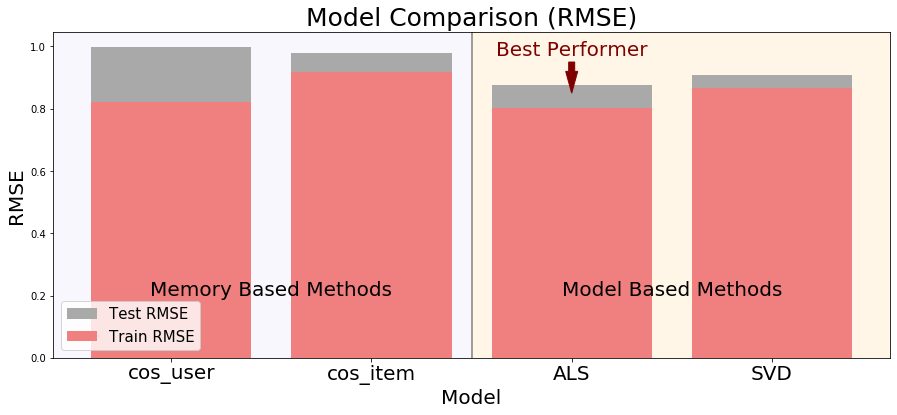

In [427]:
fitted_models_names = ['cos_user', 'cos_item', 'ALS', 'SVD']

fig2, ax = plt.subplots(figsize = (15,6))
ax.fill_between(np.linspace(-1, 1.5, 1000), 2, alpha = 0.3, color = 'lavender')
ax.fill_between(np.linspace(1.5, 4, 1000), 2, alpha = 0.3, color = 'moccasin')
ax.bar(fitted_models_names, test_RMSEs, label = 'Test RMSE', color = 'darkgray')
ax.bar(fitted_models_names, train_RMSEs, label = 'Train RMSE', color = 'lightcoral')
ax.legend(loc = 3, fontsize = 15)
ax.annotate('Memory Based Methods', # this is the text
                (0.5,0.2), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,0), # distance from text to points (x,y)
                ha='center',
                fontsize = 20,
                color = 'black')
ax.annotate('Model Based Methods', # this is the text
                (2.5,0.2), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,0), # distance from text to points (x,y)
                ha='center',
                fontsize = 20,
                color = 'black')
ax.annotate('Best Performer', # this is the text
                (2.0,0.97), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,0), # distance from text to points (x,y)
                ha='center',
                fontsize = 20,
                color = 'maroon')
#ax.axvline(2.0, 0.85, 0.9, color = 'darkblue')
ax.arrow(2.0, 0.95, 0, -0.03, width = 0.03, head_width=0.06, head_length=0.07, color = 'maroon')
ax.set_xlabel('Model', fontsize = 20)
ax.set_ylabel('RMSE', fontsize = 20)
ax.set_xticklabels(fitted_models_names, fontsize = 20)
ax.axvline(1.5, 0, 1.0, color = 'grey')
ax.set_title('Model Comparison (RMSE)', fontsize = 25);

<font size="4">Based on the RMSE scores the model based methods performed better than the memory based methods. <br>
The winning model overall the ALS model returning a mean train RMSE of 0.8 and a mean test RMSE of 0.88.<font> 

In [44]:
ALS_algo.bsl_options

{'method': 'als', 'n_epochs': 10, 'reg_u': 10, 'reg_i': 3}

In [77]:
#  convert 'data' into a trainset format that is compatible with Surprise modelling
trainset = data.build_full_trainset()

In [79]:
ALS_algo.fit(trainset)

Estimating biases using als...


In [80]:
valset = data.construct_testset(val_raw_ratings)
predictions = ALS_algo.test(valset)
print('Unbiased accuracy on validation set,', end=' ')
accuracy.rmse(predictions)

Unbiased accuracy on validation set, RMSE: 0.8641


0.8640880468612688

**Not a brilliant model.... the model had an RMSE of about 0.86 on the validation set, meaning that it was off by nearly 1 whole point for each guess it made for ratings.<br>
But the best model we have**

**<font color=black>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------<font>**

### Test chosen collaborative model and make predictions:

In [84]:
#  use the first 10 sa,mples from the ratings table as the comparison
ratings_clean[:10]

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0
6,1,101,5.0
7,1,110,4.0
8,1,151,5.0
9,1,157,5.0


In [147]:
#  using the chosen ALS model predict the first 10 samples above
for i in range(10):
    print(ratings_clean.userId[i], ratings_clean.movieId[i],
          round(ALS_algo.predict(uid = ratings_clean.userId[i], iid = ratings_clean.movieId[i])[3],2))

1 1 4.68
1 3 4.07
1 6 4.71
1 47 4.77
1 50 5.0
1 70 4.41
1 101 4.61
1 110 4.79
1 151 4.26
1 157 3.87


**The hit or miss effect of a model with an RMSE of 0.88 is exhibited above. <br>
Some predictions are close and others aren't and the ones that aren't are approximately 1 point out.**

**<font color=black>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------<font>**

In [87]:
ratings_clean_copy = ratings_clean.copy()

In [112]:
ratings_count = pd.DataFrame(ratings_clean_copy.groupby('movieId').count() \
                             ['rating']).reset_index().rename(columns={"rating": "ratings_count"})

In [128]:
ratings_count['ratings_count_rank'] = ratings_count['ratings_count'].rank(method = 'max', ascending = False)

In [132]:
ratings_count.sort_values(by = ['ratings_count'], ascending = False).head()

,movieId,ratings_count,ratings_count_rank
314,356,329,1.0
277,318,317,2.0
257,296,307,3.0
510,593,279,4.0
1938,2571,278,5.0


In [130]:
ratings_count.tail()

,movieId,ratings_count,ratings_count_rank
9719,193581,1,9724.0
9720,193583,1,9724.0
9721,193585,1,9724.0
9722,193587,1,9724.0
9723,193609,1,9724.0


In [150]:
user_7_already_rated = ratings_clean_copy[ratings_clean_copy.userId == 9]['movieId'].unique()
user_7_not_rated = [x for x in movies['movieId'] if x not in user_7_already_rated]

In [151]:
movies_rated_by_highrating_7 = ratings_clean_copy.loc[(ratings['movieId'].isin(user_7_already_rated)) & \
                                            (ratings_clean_copy['userId'] == 9)].sort_values(by=['rating'], \
                                                                                   ascending = False)

In [152]:
movies_rated_by_highrating_7[:10].merge(movies, how = 'left', \
                                         on = 'movieId').merge(ratings_count.loc[:,['movieId', 'ratings_count_rank']],\
                                                               how = 'left', on = 'movieId')

,userId,movieId,rating,title,genres,ratings_count_rank
0,9,5902,5.0,Adaptation (2002),Comedy|Drama|Romance,507.0
1,9,1198,5.0,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,19.0
2,9,5952,5.0,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,26.0
3,9,2300,5.0,"Producers, The (1968)",Comedy,806.0
4,9,5481,5.0,Austin Powers in Goldmember (2002),Comedy,292.0
5,9,1270,5.0,Back to the Future (1985),Adventure|Comedy|Sci-Fi,35.0
6,9,4993,5.0,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,20.0
7,9,923,5.0,Citizen Kane (1941),Drama|Mystery,264.0
8,9,6001,4.0,"King of Comedy, The (1983)",Comedy|Drama,2949.0
9,9,922,4.0,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance,976.0


In [153]:
ratings_sorted = []

for m_id in user_7_not_rated:

    user_prediction = ALS_algo.predict(9, m_id)

    pred_rating = user_prediction[3]
    pred_movie = movies.loc[movies['movieId'] == user_prediction[1], 'title'].iloc[0]
    pred_movieId = movies.loc[movies['movieId'] == user_prediction[1], 'movieId'].iloc[0]
    pred_movie_genre = movies.loc[movies['movieId'] == user_prediction[1], 'genres'].iloc[0]
    ratings_sorted.append((pred_movieId, pred_movie, pred_movie_genre, pred_rating))
    
ratings_sorted.sort(key = lambda x: x[3], reverse = True)

In [154]:
pd.DataFrame(ratings_sorted[:10], columns = ['movieId', 'title', 'genre', \
                                             'predicted_rating']).merge(ratings_count.loc[:,['movieId', \
                                                                                             'ratings_count_rank']],\
                                                               how = 'left', on = 'movieId')

,movieId,title,genre,predicted_rating,ratings_count_rank
0,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.218056,2.0
1,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.185901,146.0
2,1235,Harold and Maude (1971),Comedy|Drama|Romance,4.183043,1012.0
3,1208,Apocalypse Now (1979),Action|Drama|War,4.168120,116.0
4,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,4.162496,61.0
5,1237,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Drama,4.155643,1419.0
6,912,Casablanca (1942),Drama|Romance,4.154677,138.0
7,1262,"Great Escape, The (1963)",Action|Adventure|Drama|War,4.153472,573.0
8,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller,4.144827,1498.0
9,48516,"Departed, The (2006)",Crime|Drama|Thriller,4.144812,116.0


**<font color=black>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------<font>**

## Content Based Model

In [294]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
import re
from sklearn.decomposition import TruncatedSVD

/Users/flatiron/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [255]:
tags_2 = tags.loc[:, ['movieId', 'tag']]

In [256]:
tags_2.head()

,movieId,tag
0,60756,funny
1,60756,Highly quotable
2,60756,will ferrell
3,89774,Boxing story
4,89774,MMA


In [257]:
def find_year(string):
    
    # will extract the year of release from the movie title and convert to the decade of release
    
    pattern = '(\(\d{4}\))'
    p = re.compile(pattern)
    digits = p.findall(string)
    
    if digits == []:
        return ''
    else:    
        year = (int(''.join(digits).replace('(', '').replace(')', '')) // 10) * 10
        return str(year)+'s'

In [258]:
movies['decade'] = movies['title'].map(lambda x: find_year(x.strip()[-6:]))

In [259]:
def check_year_in_title(string):
    
    # will extract the year of release from the movie title and convert to the decade of release
    
    pattern = '(\(\d{4}\))'
    p = re.compile(pattern)
    digits = p.findall(string)
    
    if digits == []:
        return ''
    else:    
        year = ''.join(digits)
        return year

In [260]:
movies['title_clean'] = movies['title'].apply(lambda x: x.replace(check_year_in_title(x.strip()), '').strip() \
                                              if check_year_in_title(x.strip()) != '' else x.strip())

In [261]:
movies.head()

,movieId,title,genres,decade,title_clean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1990s,Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,1990s,Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,1990s,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1990s,Waiting to Exhale
4,5,Father of the Bride Part II (1995),Comedy,1990s,Father of the Bride Part II


In [262]:
m_tags = {}
for col in ['genres', 'decade', 'title_clean']:
    for m_id in movies['movieId'].unique():
        for i in movies[movies['movieId'] == m_id][col]:
            if m_id in m_tags:
                m_tags[m_id].append(' '.join(i.lower().split('|')))
            else:
                m_tags[m_id] = i.lower().split('|')

In [287]:
#m_tags

In [264]:
m_tags_list = list(m_tags.values())

In [288]:
m_tags_list[:5]

[['adventure',
  'animation',
  'children',
  'comedy',
  'fantasy',
  '1990s',
  'toy story'],
 ['adventure', 'children', 'fantasy', '1990s', 'jumanji'],
 ['comedy', 'romance', '1990s', 'grumpier old men'],
 ['comedy', 'drama', 'romance', '1990s', 'waiting to exhale'],
 ['comedy', '1990s', 'father of the bride part ii']]

In [266]:
stopwords_list = stopwords.words('english')

stopwords_list += list(string.punctuation)

In [267]:
def process_article(article):
    
    article = ' '.join(article)
    
    tokens = word_tokenize(article) 
    #   word_tokenize splits text into a list of strings split based on white 
    #   space (or aposraphes)

    tokens_2 = [] 
    # empty list to store only relevant (lowercased) tokens that aren't in the 
    #   stopword list
    
    for token in tokens:
    
        if token.lower() not in stopwords_list:
                
            tokens_2.append(token.lower())
                
    return tokens_2

In [268]:
processed_data = list(map(process_article, m_tags_list))

In [269]:
len(processed_data) 

9742

In [271]:
len(movies['movieId'].unique())

9742

In [270]:
processed_data[:5]

[['adventure',
  'animation',
  'children',
  'comedy',
  'fantasy',
  '1990s',
  'toy',
  'story'],
 ['adventure', 'children', 'fantasy', '1990s', 'jumanji'],
 ['comedy', 'romance', '1990s', 'grumpier', 'old', 'men'],
 ['comedy', 'drama', 'romance', '1990s', 'waiting', 'exhale'],
 ['comedy', '1990s', 'father', 'bride', 'part', 'ii']]

In [272]:
total_vocab = set()
for doc in processed_data:
    total_vocab.update(doc)

In [275]:
len(total_vocab)

9273

In [276]:
articles_concat = []
for doc in processed_data:
    articles_concat += doc

In [280]:
freqdist = FreqDist(articles_concat)

In [281]:
freqdist

FreqDist({'drama': 4362, 'comedy': 3768, '2000s': 2849, '1990s': 2212, '2010s': 1931, 'thriller': 1895, 'action': 1836, 'romance': 1603, 'adventure': 1279, 'crime': 1210, ...})

In [282]:
most_common = freqdist.most_common(20)

most_common 

[('drama', 4362),
 ('comedy', 3768),
 ('2000s', 2849),
 ('1990s', 2212),
 ('2010s', 1931),
 ('thriller', 1895),
 ('action', 1836),
 ('romance', 1603),
 ('adventure', 1279),
 ('crime', 1210),
 ('1980s', 1177),
 ('horror', 985),
 ('sci-fi', 980),
 ('fantasy', 782),
 ('children', 691),
 ('animation', 612),
 ('mystery', 583),
 ('1970s', 500),
 ('documentary', 440),
 ('war', 421)]

<BarContainer object of 20 artists>

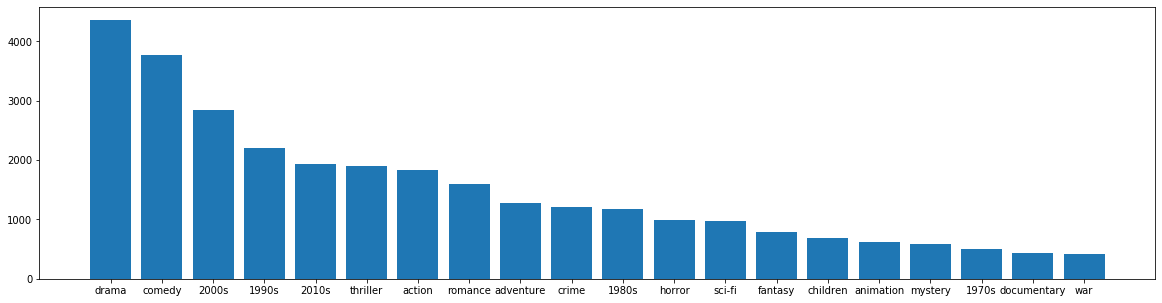

In [286]:
plt.figure(figsize = (20, 5))
plt.bar([word[0] for word in most_common], [word[1] for word in most_common])

In [289]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), stop_words=stopwords_list)

In [290]:
m_tags_list_2 = [' '.join(x) for x in m_tags_list]

In [291]:
tf_idf_data_train = vectorizer.fit_transform(m_tags_list_2)

In [292]:
type(tf_idf_data_train)

scipy.sparse.csr.csr_matrix

In [293]:
tf_idf_data_train.shape

(9742, 28738)

<font size="3">Over 28,000 features as a result of TF-IDF vectorisation. <br>
    Dimensionality reduction will be attempted, with the aim of retaining at least 90% explained variance<font>

In [302]:
# Instantiate SVD
svd = TruncatedSVD(n_components=8000, n_iter=7, random_state=42)

# fit and transform on vectorised tf-idf matrix
tf_idf_data_train_svd = svd.fit_transform(tf_idf_data_train)

In [303]:
print(svd.explained_variance_ratio_.sum())

0.9604608646851812


<font size="3">Original matrix of +28,000 dimensions has been reduced to 8,000 components while retaining 96% of the explained variance.<font>

### Calculate TF-IDF similarities between movies

<font size="3">**Cosine Similarity** will be used to calculate the similarity between all pairwise movies. 

As we are performing similarity calculations on a TF-IDF Vectorized matrix, simply calculating the dot product for each pairing will be equivalent to the Cosine Similarity Score. This means sklearn's linear_kernel can be used instead of the cosine kernel as it is much faster.<font>

In [304]:
cosine_sim = linear_kernel(tf_idf_data_train_svd, tf_idf_data_train_svd)

In [307]:
cosine_sim.shape

(9742, 9742)

In [313]:
movies_2 = movies.reset_index()

# extract all unique movie IDs
m_ids = movies_2['movieId']

# extract the movies' position within the movies dataset which also corresponds to its position within the 
# TF-IDF vectorised matrix (from which we will extract similarity scores later on)
indices = pd.Series(movies_2.index, index=movies['movieId'])

In [354]:
def get_most_similar_movies(movieid, n = 20):
    
    # this function will, for any given movieId, obtain the 50 most similar movies (based on their TF-IDF score)
    idx = indices[movieid]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:n]   # not [0:51] because the the 0 position movie will be the originally specified
                                    # movie as it will be the most similar to itself.
    movie_indices = [i[0] for i in sim_scores]

    recs = pd.DataFrame(columns = movies_2.columns)
    for i in m_ids.iloc[movie_indices]:
        
        if i != movieid:
            recs = recs.append(movies_2[movies_2['movieId'] == i])
    
    return recs

In [357]:
movies[movies['movieId'] == 5]

,movieId,title,genres,decade,title_clean
4,5,Father of the Bride Part II (1995),Comedy,1990s,Father of the Bride Part II


In [356]:
get_most_similar_movies(5)

,index,movieId,title,genres,decade,title_clean
4645,4645,6944,Father of the Bride (1991),Comedy,1990s,Father of the Bride
715,715,934,Father of the Bride (1950),Comedy,1950s,Father of the Bride
1974,1974,2620,This Is My Father (1998),Drama|Romance,1990s,This Is My Father
5176,5176,8380,Father Hood (1993),Comedy,1990s,Father Hood
5591,5591,26871,My Father the Hero (1994),Comedy|Romance,1990s,My Father the Hero
2294,2294,3041,Meatballs Part II (1984),Comedy,1980s,Meatballs Part II
7612,7612,86911,"Hangover Part II, The (2011)",Comedy,2010s,"Hangover Part II, The"
922,922,1221,"Godfather: Part II, The (1974)",Crime|Drama,1970s,"Godfather: Part II, The"
6500,6500,53435,Hostel: Part II (2007),Crime|Horror|Thriller,2000s,Hostel: Part II
2154,2154,2868,Fright Night Part II (1988),Horror,1980s,Fright Night Part II


In [358]:
def rated_notrated(userid):
    movies_already_rated = list(ratings_clean_copy[ratings_clean_copy.userId == userid]['movieId'].unique())
    movies_not_rated = [x for x in movies['movieId'] if x not in movies_already_rated]
    
    return movies_already_rated, movies_not_rated

In [363]:
def predicted_ratings_for_unrated(userid, movies_already_rated, movies_not_rated):
    ratings_sorted = []

    for m_id in movies_not_rated:

        user_prediction = ALS_algo.predict(userid, m_id)

        pred_rating = user_prediction[3]
        pred_movie = movies.loc[movies['movieId'] == user_prediction[1], 'title'].iloc[0]
        pred_movie_genre = movies.loc[movies['movieId'] == user_prediction[1], 'genres'].iloc[0]
        ratings_sorted.append((pred_movie, pred_movie_genre, pred_rating))
    
    return ratings_sorted.sort(key = lambda x: x[2], reverse = True)

In [409]:
def top_rated_movies(userid, n = 20):
    
    movies_already_rated, movies_not_rated = rated_notrated(userid)    

    movies_already_rated_by_highest = ratings_clean_copy.loc[(ratings_clean_copy['movieId'].isin(movies_already_rated)) & \
                                            (ratings_clean_copy['userId'] == userid)].sort_values(by=['rating'], \
                                                                                   ascending = False)
    movies_already_rated_by_highest = movies_already_rated_by_highest[['movieId', 'rating']][:n]
    
    top_n = movies[movies['movieId'].isin(movies_already_rated_by_highest['movieId'])]
    
    top_n = top_n.merge(movies_already_rated_by_highest, how = 'left', on = 'movieId')
    
    top_n = top_n.sort_values(by = ['rating'], ascending = False)
    
    return top_n

In [410]:
def make_hybrid_recommendation(userid, movies_already_rated_by_highest, movies_already_rated):
    rec_list = []
    for i in movies_already_rated_by_highest['movieId']:
        for j in get_most_similar_movies(i)['movieId']:
            content_recommended = movies_2[movies_2['movieId'] == j]
            rec_list.append((j, content_recommended['title'].iloc[0], ALS_algo.predict(userid, content_recommended['movieId'].iloc[0])[3]))

    rec_list = [x for x in rec_list if x[0] not in movies_already_rated]
    
    rec_list = list(set(rec_list))
    
    rec_list.sort(key = lambda x: x[2], reverse= True)
    
    

    return rec_list


In [411]:
def recommend_to_existing_user(userid, n = 10):
    
    movies_already_rated, movies_not_rated = rated_notrated(userid)
    
    movies_already_rated_by_highest = top_rated_movies(userid)
    
    rec_list = make_hybrid_recommendation(userid, movies_already_rated_by_highest, movies_already_rated)
    
    return rec_list[:n]

In [412]:
top_rated_movies(9)

,movieId,title,genres,decade,title_clean,rating
3,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,1980s,Raiders of the Lost Ark (Indiana Jones and the...,5.0
4,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi,1980s,Back to the Future,5.0
16,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,2000s,"Lord of the Rings: The Two Towers, The",5.0
7,2300,"Producers, The (1968)",Comedy,1960s,"Producers, The",5.0
8,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,2000s,"Lord of the Rings: The Fellowship of the Ring,...",5.0
15,5902,Adaptation (2002),Comedy|Drama|Romance,2000s,Adaptation,5.0
1,923,Citizen Kane (1941),Drama|Mystery,1940s,Citizen Kane,5.0
12,5481,Austin Powers in Goldmember (2002),Comedy,2000s,Austin Powers in Goldmember,5.0
0,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance,1950s,Sunset Blvd. (a.k.a. Sunset Boulevard),4.0
13,5890,Elling (2001),Comedy|Drama,2000s,Elling,4.0


In [413]:
pd.DataFrame(recommend_to_existing_user(9), \
             columns = ['movieId', \
                        'Title', \
                        'Predicted_Score']).merge(\
                                                  ratings_count.loc[:, ['movieId', 'ratings_count_rank']],\
                                                  how = 'left', on = 'movieId')

,movieId,Title,Predicted_Score,ratings_count_rank
0,1208,Apocalypse Now (1979),4.053262,116.0
1,7361,Eternal Sunshine of the Spotless Mind (2004),4.008923,72.0
2,930,Notorious (1946),4.006261,1297.0
3,3836,Kelly's Heroes (1970),3.954639,1650.0
4,7153,"Lord of the Rings: The Return of the King, The...",3.940819,27.0
5,928,Rebecca (1940),3.933060,1419.0
6,6711,Lost in Translation (2003),3.924319,240.0
7,913,"Maltese Falcon, The (1941)",3.920273,549.0
8,1272,Patton (1970),3.911460,806.0
9,5008,Witness for the Prosecution (1957),3.909399,2441.0


<font size="3">To judge whether the movies being recommended are from the head or the long-tail take note of the column<font> <font size="4">**`ratings_count_rank`<font>**
<font size="3"> in the above dataframe. <br>
A rank score greater than 2,000 indicates a movie from the long tail of which there is only one that has been recommended (Down by Law (1986) - ranked 2,121).<br><br>
It seems that the hybrid recommender system has fallen into the “rich-get-richer” problem whereby the more popular items (from the head of the long-tail distribution) are being recommended rather than the less popular movies from the long-tail.

A possible reason for this could be the lack of metadata tagging of the movies within the database thus limiting the ability of calculating TF-IDF similarity within the content based model. The only 'tags' that the content based model
has used to measure similarity is the movie title and genre which has inclined it to recommending sequels and prequels.<font>



### Build a user input interface

In [397]:
distinct_genres = set()
for genre in list(movies.genres.unique()):
    distinct_genres.update(genre.lower().split('|'))

print('distinct genres:\n', list(distinct_genres),'\n')
print('numnber distinct genres:', len(distinct_genres)-1)

distinct genres:
 ['adventure', 'romance', 'fantasy', 'war', 'drama', 'animation', 'documentary', 'sci-fi', 'thriller', 'western', '(no genres listed)', 'children', 'action', 'horror', 'mystery', 'musical', 'crime', 'film-noir', 'imax', 'comedy'] 

numnber distinct genres: 19


In [417]:
def user_signin():
    userid = input("""Please enter your userId
    If you are a new user then please leave blank\n\n""")
    
    if userid:
        userid = int(userid)
    else:
        userid = ratings_clean_copy.userId.max()+1
        
    return userid

In [418]:
def lists_overlap(a, b):
    for i in a:
        if i in b:
            return 1
    return 0

In [419]:
def ALS_fit():
    #  convert 'data' into a trainset format that is compatible with Surprise modelling
    data = MyDataset(ratings_clean_copy, reader)

    trainset = data.build_full_trainset()

    ALS_algo.fit(trainset)

In [456]:

def cold_start_recommender(n = 10):
    global ratings_clean_copy
    
    userid = user_signin()
    
    ####################################################################
    print('\n\n',list(distinct_genres))
    
    selected_genres = input("""\nAre you a fan on any particular genres? 
    If so please select from the above list (separated by a ',')
    otherwise please type 'no'\n\n""")
    
    selected_genres = list(selected_genres.lower().split(','))
    ####################################################################
    
    movies_db = movies.copy()             
                            
    if (selected_genres == ['no'] or lists_overlap(list(distinct_genres), selected_genres) == False):
        movies_db['flag'] = 1
    else:
        movies_db['flag'] = movies['genres'].map(lambda x: lists_overlap(x.lower().split('|'), selected_genres))
    
    movies_db = movies_db[movies_db['flag'] == 1]
    ####################################################################
    
    random_movie_index = random.sample(range(1, len(movies_db)), n)
    
    for i in random_movie_index:
        random_movie = movies_db.iloc[i]
    
        print('\nOn a scale of 0-5, what would you rate this movie?\n')
        print('movie name:', random_movie[1])
        print('movie genre:', random_movie[2])
        print("\nIf you would prefer to not rate then please type 'skip'")

        while True:
            try:
                userInput = input()
                if userInput == 'skip':
                    break
                elif int(userInput) > 5 or int(userInput) < 0:
                    userInput = int('a')
                elif int(userInput) >= 0 or int(userInput) <= 5:
                    ratings_clean_copy = ratings_clean_copy.append(pd.DataFrame([[random_movie[0], float(userInput), userid]], \
                                                                                columns = ['movieId', 'rating', 'userId']), \
                                                                   ignore_index=True)
            except ValueError:
                print("please enter a rating between 0-5")
                continue
            else:
                userInput
                break
    
    ALS_fit()
    
    return pd.DataFrame(recommend_to_existing_user(userid), \
             columns = ['movieId', \
                        'Title', \
                        'Predicted_Score']).merge(\
                                                  ratings_count.loc[:, ['movieId', 'ratings_count_rank']],\
                                                  how = 'left', on = 'movieId')
    ####################################################################

In [458]:
cold_start_recommender(5)

Please enter your userId
    If you are a new user then please leave blank


 ['adventure', 'romance', 'fantasy', 'war', 'drama', 'animation', 'documentary', 'sci-fi', 'thriller', 'western', '(no genres listed)', 'children', 'action', 'horror', 'mystery', 'musical', 'crime', 'film-noir', 'imax', 'comedy']


Are you a fan on any particular genres? 
    If so please select from the above list (separated by a ',')
    otherwise please type 'no'

romance,comedy,horror

On a scale of 0-5, what would you rate this movie?

movie name: In America (2002)
movie genre: Drama|Romance

If you would prefer to not rate then please type 'skip'
2

On a scale of 0-5, what would you rate this movie?

movie name: Charlie's Angels: Full Throttle (2003)
movie genre: Action|Adventure|Comedy|Crime|Thriller

If you would prefer to not rate then please type 'skip'
4

On a scale of 0-5, what would you rate this movie?

movie name: O Brother, Where Art Thou? (2000)
movie genre: Adventure|Comedy|Crime

If you woul

,movieId,Title,Predicted_Score,ratings_count_rank
0,4011,Snatch (2000),4.180390,156.0
1,1387,Jaws (1975),4.054398,169.0
2,3549,Guys and Dolls (1955),3.968112,2671.0
3,4437,Suspiria (1977),3.944588,2671.0
4,7387,Dawn of the Dead (1978),3.935932,1297.0
5,54281,Charlie Bartlett (2007),3.896226,3650.0
6,5328,Rain (2001),3.894005,9724.0
7,3676,Eraserhead (1977),3.869111,2269.0
8,5377,About a Boy (2002),3.810992,549.0
9,44929,Candy (2006),3.810013,6278.0


In [422]:
# check that the new user and ratings have been added to the ratings table
ratings_clean_copy.tail(10)

,movieId,rating,userId
100835,170875,3.0,610
100836,71518,2.0,611
100837,49220,3.0,611
100838,468,4.0,611
100839,6803,3.0,611
100840,4079,4.0,611
100841,3230,5.0,611
100842,26681,4.0,612
100843,27036,3.0,612
100844,72294,3.0,612
